In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

**Get dataset**

In [3]:
#!pip install opendatasets
#import opendatasets as od
#od.download('https://www.kaggle.com/kmader/satellite-images-of-hurricane-damage')

**Build database with filenames and labels**

In [4]:
def get_files(directory):
    df = pd.DataFrame(columns=['file','target'])
    damage = glob.glob(directory+'/damage/*.jpeg')
    no_damage = glob.glob(directory+'/no_damage/*jpeg')
    for f in damage:
        df = df.append({'file':f,'target':'1'},ignore_index=True)
    for f in no_damage:
        df = df.append({'file':f,'target':'0'},ignore_index=True)
    return df

def get_image(file_path):
    return mpimg.imread(file_path)/255

In [5]:
df_train = pd.concat([get_files('../input/satellite-images-of-hurricane-damage/train_another'),
                      get_files('../input/satellite-images-of-hurricane-damage/test_another'),
                      get_files('../input/satellite-images-of-hurricane-damage/validation_another')],axis=0)
df_test = get_files('../input/satellite-images-of-hurricane-damage/test')

In [6]:
df_train.reset_index(inplace=True,drop=True)

In [7]:
df_train.head()

,file,target
0,../input/satellite-images-of-hurricane-damage/...,1
1,../input/satellite-images-of-hurricane-damage/...,1
2,../input/satellite-images-of-hurricane-damage/...,1
3,../input/satellite-images-of-hurricane-damage/...,1
4,../input/satellite-images-of-hurricane-damage/...,1


**Visualize some data**

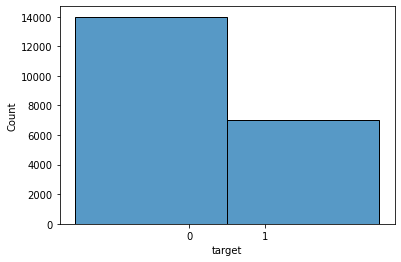

In [8]:
ax = sns.histplot(x='target', data=df_train, bins=2)
ax.set_xticks([0.25,0.75])
ax.set_xticklabels([0,1])
plt.show()

In [9]:
img = get_image(df_train[df_train['target']=='1']['file'].iloc[0])
img.shape

(128, 128, 3)

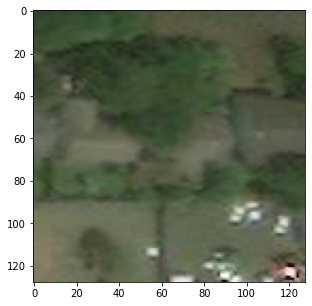

In [10]:
fig = plt.figure(figsize=(5,5))
plt.imshow(img)

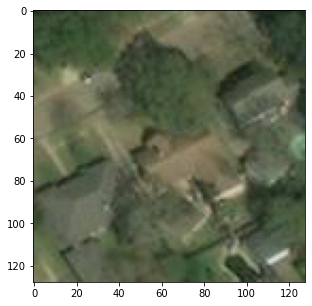

In [11]:
fig = plt.figure(figsize=(5,5))
plt.imshow(get_image(df_train[df_train['target']=='0']['file'].iloc[0]))

**Define the data structure for the model**

In [ ]:
train_gen = ImageDataGenerator(validation_split=0.1)
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'file',
    y_col = 'target',
    target_size = (256,256),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    subset = 'training',
    batch_size=100
)

val_data = train_gen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'file',
    y_col = 'target',
    target_size = (256,256),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False,
    subset = 'validation',
    batch_size=100
)

test_data = test_gen.flow_from_dataframe(
    dataframe = df_test,
    x_col = 'file',
    y_col = 'target',
    target_size = (256,256),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False,
    batch_size=100
)

**Create model**

In [42]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 96)        34944     
_________________________________________________________________
batch_normalization_10 (Batc (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 30, 256)       614656    
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 30, 256)       1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 384)      

**Fit model**

In [43]:
history = model.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
189/189 [==============================] - 60s 306ms/step - loss: 1.0468 - accuracy: 0.6361 - recall: 0.7123 - val_loss: 0.5635 - val_accuracy: 0.7533 - val_recall: 0.7533
Epoch 2/15
189/189 [==============================] - 58s 305ms/step - loss: 0.7011 - accuracy: 0.7707 - recall: 0.8326 - val_loss: 0.3257 - val_accuracy: 0.8738 - val_recall: 0.8738
Epoch 3/15
189/189 [==============================] - 58s 304ms/step - loss: 0.5958 - accuracy: 0.8041 - recall: 0.8556 - val_loss: 0.1964 - val_accuracy: 0.9167 - val_recall: 0.9167
Epoch 4/15
189/189 [==============================] - 58s 308ms/step - loss: 0.5129 - accuracy: 0.8319 - recall: 0.8754 - val_loss: 0.2127 - val_accuracy: 0.9119 - val_recall: 0.9119
Epoch 5/15
189/189 [==============================] - 58s 308ms/step - loss: 0.4662 - accuracy: 0.8477 - recall: 0.8842 - val_loss: 0.2269 - val_accuracy: 0.9038 - val_recall: 0.9038
Epoch 6/15
189/189 [==============================] - 58s 306ms/step - loss: 0.4144 -

**Evaluate model**

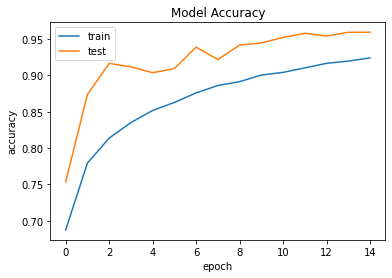

In [44]:
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

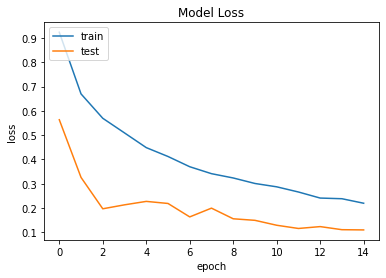

In [45]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
y_pred = model.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

In [55]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1000
           1       0.92      0.95      0.94      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [56]:
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

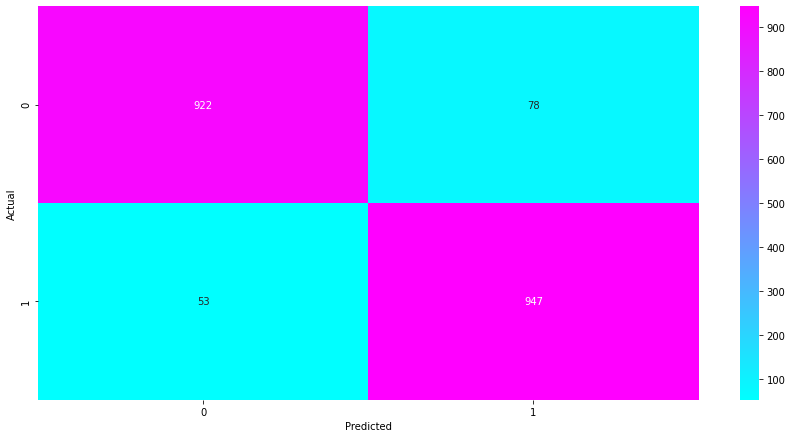

In [57]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Try transfer learning with imagenet**

In [21]:
model = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(256,256,3)),
        keras.layers.Conv2D(3,3,activation='relu',padding='same'),
        EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(32,activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')])

model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall'])
model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 3)       84        
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,090,680
Trainable params: 4,048,657
Non-trainable params: 42,023
_________________________________________________________________


In [22]:
history = model.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
189/189 [==============================] - 187s 904ms/step - loss: 0.6930 - accuracy: 0.5279 - recall: 0.6711 - val_loss: 0.6321 - val_accuracy: 0.8500 - val_recall: 0.8500
Epoch 2/15
189/189 [==============================] - 163s 860ms/step - loss: 0.6339 - accuracy: 0.6753 - recall: 0.8088 - val_loss: 0.7166 - val_accuracy: 0.3962 - val_recall: 0.3962
Epoch 3/15
189/189 [==============================] - 161s 850ms/step - loss: 0.5847 - accuracy: 0.7579 - recall: 0.8551 - val_loss: 0.5093 - val_accuracy: 0.8867 - val_recall: 0.8867
Epoch 4/15
189/189 [==============================] - 161s 851ms/step - loss: 0.5274 - accuracy: 0.8280 - recall: 0.8705 - val_loss: 0.4142 - val_accuracy: 0.8995 - val_recall: 0.8995
Epoch 5/15
189/189 [==============================] - 161s 851ms/step - loss: 0.4783 - accuracy: 0.8607 - recall: 0.8808 - val_loss: 0.3652 - val_accuracy: 0.8986 - val_recall: 0.8986
Epoch 6/15
189/189 [==============================] - 161s 853ms/step - loss: 0.

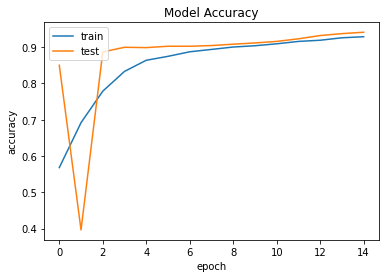

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

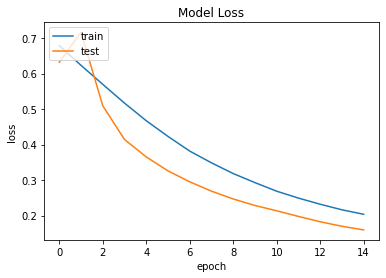

In [24]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
y_pred = model.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

In [26]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93      1000
           1       0.91      0.94      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



In [27]:
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

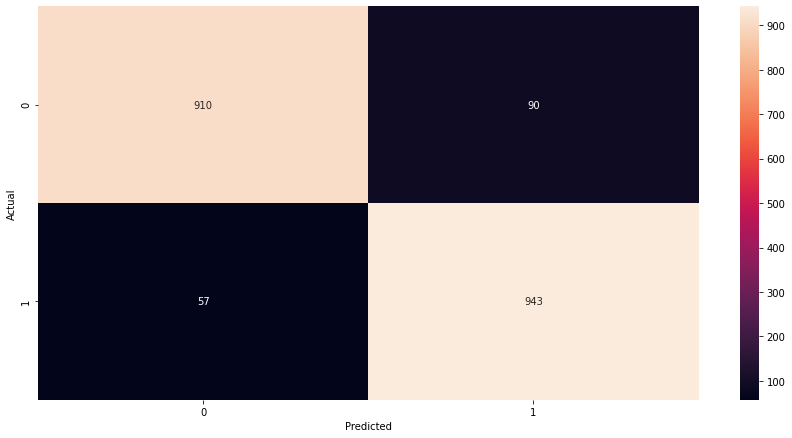

In [29]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Try out SVM model**

In [12]:
train_idx =  df_train['file'].values
y = df_train['target'].values
test_idx =  df_test['file'].values
y_test = df_test['target'].values
x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.5,random_state=42,stratify=y)

In [13]:
x_train_img = np.zeros((len(x_train),128*128*3))
for i,f in enumerate(x_train):
    x_train_img[i,:] = get_image(f).reshape(-1)
    

In [ ]:
x_valid_img = np.zeros((len(x_valid),128*128*3))
for i,f in enumerate(x_valid):
    x_valid_img[i,:] = get_image(f).reshape(-1)    
  

In [ ]:
  
x_test_img = np.zeros((len(test_idx),128*128*3))
for i,f in enumerate(test_idx):
    x_test_img[i,:] = get_image(f).reshape(-1)     

In [ ]:
svm = SVC()
svm.fit(x_train_img,y_train)

In [ ]:
y_pred = model.predict(x_valid_img)
print(classification_report(y_valid,y_pred))

In [ ]:
con_mat_df = pd.DataFrame(confusion_matrix(y_valid,y_pred))

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Add efficientnet to 1st model**

In [59]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(1,1), activation='relu', input_shape=(256,256,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(1,1)),
    EfficientNetB0(include_top=False,weights='imagenet'),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_208 (Conv2D)          (None, 246, 246, 96)      34944     
_________________________________________________________________
batch_normalization_184 (Bat (None, 246, 246, 96)      384       
_________________________________________________________________
max_pooling2d_118 (MaxPoolin (None, 122, 122, 96)      0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 122, 122, 256)     614656    
_________________________________________________________________
batch_normalization_185 (Bat (None, 122, 122, 256)     1024      
_________________________________________________________________
max_pooling2d_119 (MaxPoolin (None, 60, 60, 256)       0         
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 60, 60, 384)     

In [60]:
history = model.fit(train_data,epochs=15,validation_data=val_data)

Epoch 1/15
189/189 [==============================] - 318s 2s/step - loss: 0.7062 - accuracy: 0.5617 - recall: 0.6549 - val_loss: 0.6506 - val_accuracy: 0.9995 - val_recall: 0.9995
Epoch 2/15
189/189 [==============================] - 196s 1s/step - loss: 0.6507 - accuracy: 0.6274 - recall: 0.8287 - val_loss: 0.4698 - val_accuracy: 0.9986 - val_recall: 0.9986
Epoch 3/15
189/189 [==============================] - 196s 1s/step - loss: 0.6124 - accuracy: 0.6695 - recall: 0.8551 - val_loss: 0.3549 - val_accuracy: 0.9886 - val_recall: 0.9886
Epoch 4/15
189/189 [==============================] - 196s 1s/step - loss: 0.5807 - accuracy: 0.6989 - recall: 0.8683 - val_loss: 0.3675 - val_accuracy: 0.9438 - val_recall: 0.9438
Epoch 5/15
189/189 [==============================] - 195s 1s/step - loss: 0.5608 - accuracy: 0.7086 - recall: 0.8506 - val_loss: 0.3441 - val_accuracy: 0.9243 - val_recall: 0.9243
Epoch 6/15
189/189 [==============================] - 196s 1s/step - loss: 0.5389 - accuracy: 0

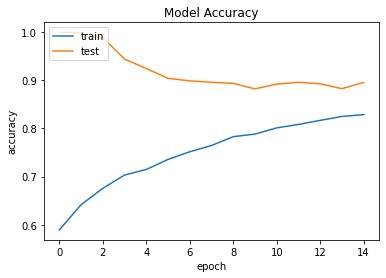

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

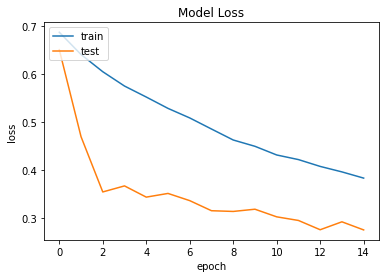

In [62]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [63]:
y_pred = model.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

In [64]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1000
           1       0.79      0.90      0.84      1000

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



In [1]:
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

In [ ]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()